In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb

# Google Colab file upload
from google.colab import files
import io

print("📊 Customer Churn Analysis Pipeline")
print("=" * 50)

# ==============================================================================
# 1. DATA UPLOAD AND LOADING
# ==============================================================================

def upload_and_load_data():
    """Upload and load data file"""
    print("\n🔄 Please upload your dataset (CSV, Excel supported)")
    uploaded = files.upload()

    filename = list(uploaded.keys())[0]
    print(f"✅ File uploaded: {filename}")

    # Load data based on file extension
    if filename.endswith('.csv'):
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    elif filename.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
    else:
        raise ValueError("Unsupported file format. Please upload CSV or Excel file.")

    print(f"📋 Dataset loaded successfully!")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")

    return df


📊 Customer Churn Analysis Pipeline


In [ ]:
# Load the data
try:
    df = upload_and_load_data()
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("\n📝 Creating sample dataset for demonstration...")

    # Create sample dataset if upload fails
    np.random.seed(42)
    n_samples = 5000

    df = pd.DataFrame({
        'customer_id': range(1, n_samples + 1),
        'tenure': np.random.randint(1, 73, n_samples),
        'monthly_charges': np.random.uniform(20, 120, n_samples),
        'total_charges': np.random.uniform(20, 8000, n_samples),
        'contract_type': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples, p=[0.5, 0.3, 0.2]),
        'payment_method': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_samples),
        'internet_service': np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples, p=[0.4, 0.4, 0.2]),
        'online_security': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.3, 0.5, 0.2]),
        'tech_support': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.3, 0.5, 0.2]),
        'streaming_tv': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.3, 0.5, 0.2]),
        'paperless_billing': np.random.choice(['Yes', 'No'], n_samples, p=[0.6, 0.4]),
        'senior_citizen': np.random.choice([0, 1], n_samples, p=[0.84, 0.16]),
        'partner': np.random.choice(['Yes', 'No'], n_samples, p=[0.5, 0.5]),
        'dependents': np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7]),
        'phone_service': np.random.choice(['Yes', 'No'], n_samples, p=[0.9, 0.1]),
        'churn': np.random.choice(['Yes', 'No'], n_samples, p=[0.27, 0.73])
    })

    print("✅ Sample dataset created for demonstration")



🔄 Please upload your dataset (CSV, Excel supported)


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
✅ File uploaded: WA_Fn-UseC_-Telco-Customer-Churn.csv
📋 Dataset loaded successfully!
   Shape: (7043, 21)
   Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
# 2. EXPLORATORY DATA ANALYSIS
# ==============================================================================

def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""
    print("\n" + "="*50)
    print("📊 EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # Basic information
    print(f"\n📋 Dataset Overview:")
    print(f"   Rows: {df.shape[0]:,}")
    print(f"   Columns: {df.shape[1]}")

    # Display first few rows
    print(f"\n🔍 First 5 rows:")
    display(df.head())

    # Data types and missing values
    print(f"\n📊 Data Types and Missing Values:")
    info_df = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Missing %': (df.isnull().sum() / len(df)) * 100
    })
    display(info_df)


In [ ]:
# Identify target column (common churn column names)
churn_cols = ['churn', 'Churn', 'churned', 'Churned', 'is_churn', 'target']
target_col = None
for col in churn_cols:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    print("⚠️ No churn column found. Please specify your target column:")
    print(f"Available columns: {list(df.columns)}")
    # Depending on the desired behavior, you might want to exit or ask for input here
    # For now, we'll just print the message and the program will continue.
    # If you need to handle this case further, uncomment the following lines:
    # target_col = input("Enter the target column name from the list: ")
    # if target_col not in df.columns:
    #     raise ValueError(f"Column '{target_col}' not found in the dataset.")


print(f"\n🎯 Target column identified: '{target_col}'")


🎯 Target column identified: 'Churn'


In [ ]:
# Churn distribution
churn_dist = df[target_col].value_counts()
churn_pct = df[target_col].value_counts(normalize=True) * 100

print(f"\n📊 Churn Distribution:")
# The following lines should be indented under the for loop
for val, count, pct in zip(churn_dist.index, churn_dist.values, churn_pct.values):
    print(f"   {val}: {count:,} ({pct:.1f}%)") # This print statement needs to be indented




📊 Churn Distribution:
   No: 5,174 (73.5%)
   Yes: 1,869 (26.5%)


In [ ]:
# 3. DATA VISUALIZATION
# ==============================================================================

def create_visualizations(df, target_col):
    """Create comprehensive visualizations"""
    if target_col is None:
        return

    print("\n" + "="*50)
    print("📈 DATA VISUALIZATIONS")
    print("="*50)

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # 1. Churn Distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Customer Churn Analysis - Overview', fontsize=16, y=1.02)

    # Churn pie chart
    churn_counts = df[target_col].value_counts()
    axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Churn Distribution')


In [ ]:
# 3. DATA VISUALIZATION
# ==============================================================================

def create_visualizations(df, target_col):
    """Create comprehensive visualizations"""
    if target_col is None:
        print("⚠️ Cannot create visualizations: No target column identified.")
        return

    print("\n" + "="*50)
    print("📈 DATA VISUALIZATIONS")
    print("="*50)

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create subplots figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Customer Churn Analysis - Overview', fontsize=16, y=1.02)

    # 1. Churn Distribution (Pie Chart)
    try:
        churn_counts = df[target_col].value_counts()
        axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
        axes[0,0].set_title('Churn Distribution')
    except Exception as e:
        print(f"❌ Error creating Churn Distribution pie chart: {e}")

    # Numeric columns analysis - Box plot and Histogram
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove target column from numeric columns if it's numeric
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    if len(numeric_cols) >= 2:
        col1 = numeric_cols[0]
        col2 = numeric_cols[1]

        # 2. Box plot for the first numeric column (if not the target)
        try:
            sns.boxplot(data=df, x=target_col, y=col1, ax=axes[0,1])
            axes[0,1].set_title(f'{col1} by Churn')
        except Exception as e:
             print(f"❌ Error creating Box plot for {col1}: {e}")

        # 3. Histogram for the second numeric column by Churn (if not the target)
        try:
            for churn_val in df[target_col].unique():
                subset = df[df[target_col] == churn_val][col2]
                axes[1,0].hist(subset.dropna(), alpha=0.7, label=f'{target_col}={churn_val}', bins=30) # Added .dropna()
            axes[1,0].set_title(f'{col2} Distribution by Churn')
            axes[1,0].legend()
        except Exception as e:
             print(f"❌ Error creating Histogram for {col2}: {e}")

        # You can add more plots to axes[1,1] here if needed

    else:
        print("⚠️ Not enough numeric columns (excluding target) to create additional visualizations.")

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
    plt.show()

# Now, call the function after loading the data and identifying the target
# perform_eda(df) # Assuming you run EDA first
# create_visualizations(df, target_col) # Call the function

In [ ]:
def create_visualizations(df, target_col):
    """Create comprehensive visualizations"""
    if target_col is None:
        print("⚠️ Cannot create visualizations: No target column identified.")
        return

    print("\n" + "="*50)
    print("📈 DATA VISUALIZATIONS")
    print("="*50)

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create subplots figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Customer Churn Analysis - Overview', fontsize=16, y=1.02)

    # 1. Churn Distribution (Pie Chart)
    try:
        churn_counts = df[target_col].value_counts()
        axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
        axes[0,0].set_title('Churn Distribution')
    except Exception as e:
        print(f"❌ Error creating Churn Distribution pie chart: {e}")

    # Numeric columns analysis - Box plot and Histogram
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove target column from numeric columns if it's numeric
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    if len(numeric_cols) >= 2:
        col1 = numeric_cols[0]
        col2 = numeric_cols[1]

        # 2. Box plot for the first numeric column (if not the target)
        try:
            sns.boxplot(data=df, x=target_col, y=col1, ax=axes[0,1])
            axes[0,1].set_title(f'{col1} by Churn')
        except Exception as e:
             print(f"❌ Error creating Box plot for {col1}: {e}")

        # 3. Histogram for the second numeric column by Churn (if not the target)
        try:
            for churn_val in df[target_col].unique():
                subset = df[df[target_col] == churn_val][col2]
                axes[1,0].hist(subset.dropna(), alpha=0.7, label=f'{target_col}={churn_val}', bins=30)
            axes[1,0].set_title(f'{col2} Distribution by Churn')
            axes[1,0].legend()
        except Exception as e:
             print(f"❌ Error creating Histogram for {col2}: {e}")

    else:
        print("⚠️ Not enough numeric columns (excluding target) to create additional visualizations.")

    # Categorical analysis - Add this section inside the function and indent correctly
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)

    # Plot a bar chart for the first categorical column vs Churn on axes[1,1]
    if categorical_cols:
        cat_col = categorical_cols[0]
        try:
            pd.crosstab(df[cat_col], df[target_col]).plot(kind='bar', ax=axes[1,1])
            axes[1,1].set_title(f'{cat_col} vs Churn')
            axes[1,1].legend(title=target_col)
            plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45, ha="right") # Added ha="right" for better label alignment
        except Exception as e:
             print(f"❌ Error creating Bar plot for {cat_col}: {e}")

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
    plt.show()

# Now, call the function after loading the data and identifying the target
# perform_eda(df) # Assuming you run EDA first
# create_visualizations(df, target_col) # Call the function


📈 DATA VISUALIZATIONS


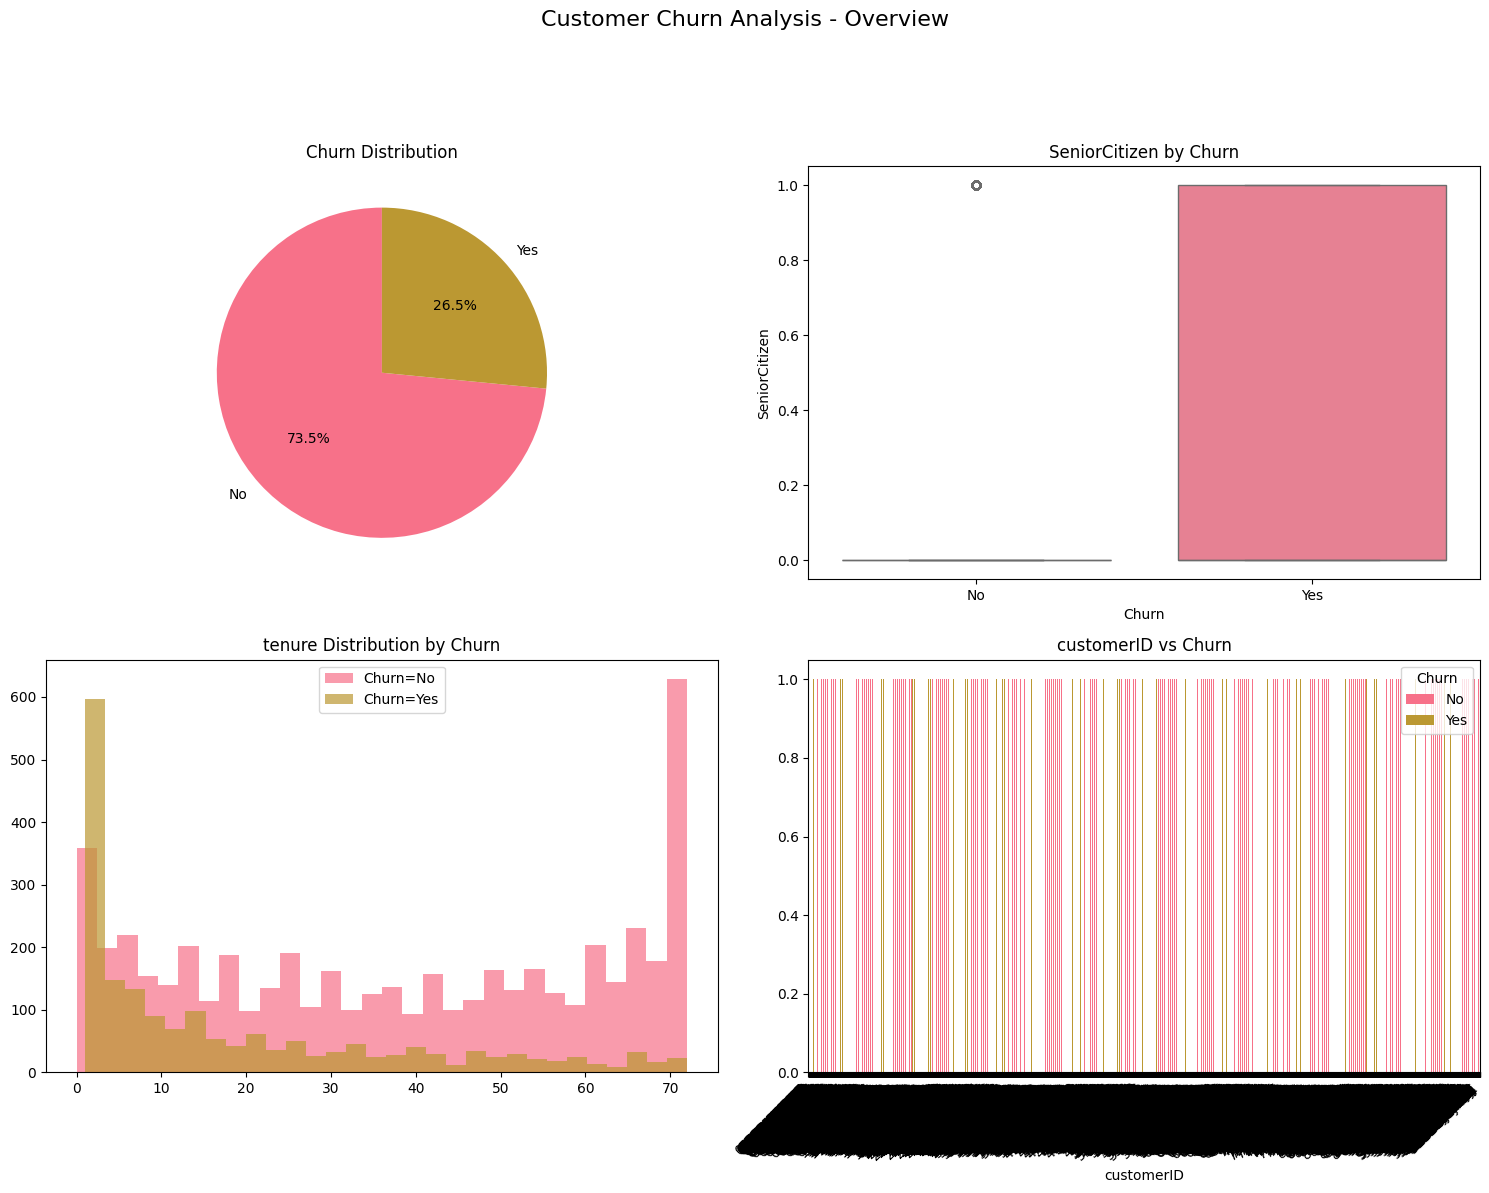

In [ ]:
# Now, call the function after loading the data and identifying the target
# perform_eda(df) # Assuming you run EDA first
create_visualizations(df, target_col) # Call the function

Here we can see from the above chart the majority of customers (73.5%) do not churn, indicating decent customer retention.
Churn is most prevalent among customers with shorter tenure, especially in the first 10 months.
Customers with longer tenure are significantly less likely to churn.
Also, one thing we can see here While senior citizens are a small portion of the base, we cannot conclude their churn behavior definitively from the current chart—further proportion-based analysis is needed.
The customer ID plot confirms the distribution of churn labels but adds limited actionable insight

In [ ]:
def preprocess_data(df, target_col):
    """Comprehensive data preprocessing"""
    if target_col is None:
        print("❌ Cannot proceed without target column")
        return None, None, None, None

    print("\n" + "="*50)
    print("🔧 DATA PREPROCESSING")
    print("="*50)

    # Create a copy for processing
    df_processed = df.copy()

    # Handle missing values
    print(f"\n🔍 Handling missing values...")
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns

    # Continue with the rest of your preprocessing steps here
    # ...

    return df_processed, numeric_cols, categorical_cols, target_col # Example return values

In [ ]:
def preprocess_data(df, target_col):
    """Comprehensive data preprocessing"""
    if target_col is None:
        print("❌ Cannot proceed without target column")
        return None, None, None, None

    print("\n" + "="*50)
    print("🔧 DATA PREPROCESSING")
    print("="*50)

    # Create a copy for processing
    df_processed = df.copy()

    # Handle missing values
    print(f"\n🔍 Handling missing values...")
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns

    # Fill categorical missing values with mode
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
            print(f"   ✅ Filled {col} with mode")

    # Encode target variable
    print(f"\n🎯 Encoding target variable '{target_col}'...")
    le_target = LabelEncoder()
    df_processed[target_col + '_encoded'] = le_target.fit_transform(df_processed[target_col])

    # Create target mapping
    target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
    print(f"   Target mapping: {target_mapping}")

    # Encode categorical variables
    print(f"\n🔤 Encoding categorical variables...")
    categorical_cols = [col for col in categorical_cols if col != target_col]

    # Use one-hot encoding for categorical variables
    df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

    # Prepare features and target
    target_encoded_col = target_col + '_encoded'
    feature_cols = [col for col in df_encoded.columns if col not in [target_col, target_encoded_col]]

    X = df_encoded[feature_cols]
    y = df_encoded[target_encoded_col]

    print(f"   ✅ Features shape: {X.shape}")
    print(f"   ✅ Target shape: {y.shape}")
    print(f"   ✅ Feature columns: {len(feature_cols)}")

    return X, y, feature_cols, target_mapping

In [ ]:

# Preprocess data
X, y, feature_cols, target_mapping = preprocess_data(df, target_col)

# ==============================================================================
# 5. MODEL TRAINING AND EVALUATION
# ==============================================================================

def train_and_evaluate_models(X, y, target_mapping):
    """Train multiple models and evaluate performance"""
    if X is None or y is None:
        print("❌ Cannot train models without processed data")
        return

    print("\n" + "="*50)
    print("🤖 MODEL TRAINING AND EVALUATION")
    print("="*50)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"✅ Data split - Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance with SMOTE
    print(f"\n⚖️ Handling class imbalance...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    print(f"   Original distribution: {pd.Series(y_train).value_counts().to_dict()}")
    print(f"   Balanced distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
    }

    results = {}

    print(f"\n🚀 Training models...")

    for name, model in models.items():
        print(f"\n   Training {name}...")

        # Train model
        model.fit(X_train_balanced, y_train_balanced)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"      Accuracy: {accuracy:.4f}")
        print(f"      F1-Score: {f1:.4f}")
        print(f"      ROC-AUC: {roc_auc:.4f}")

    # Results summary
    print(f"\n📊 MODEL COMPARISON SUMMARY")
    print("-" * 60)
    results_df = pd.DataFrame({
        name: [res['accuracy'], res['f1_score'], res['roc_auc']]
        for name, res in results.items()
    }, index=['Accuracy', 'F1-Score', 'ROC-AUC'])

    display(results_df.round(4))



🔧 DATA PREPROCESSING

🔍 Handling missing values...

🎯 Encoding target variable 'Churn'...
   Target mapping: {'No': np.int64(0), 'Yes': np.int64(1)}

🔤 Encoding categorical variables...
   ✅ Features shape: (7043, 13601)
   ✅ Target shape: (7043,)
   ✅ Feature columns: 13601


In [ ]:


# Preprocess data
X, y, feature_cols, target_mapping = preprocess_data(df, target_col)

# ==============================================================================
# 5. MODEL TRAINING AND EVALUATION
# ==============================================================================

def train_and_evaluate_models(X, y, target_mapping):
    """Train multiple models and evaluate performance"""
    if X is None or y is None:
        print("❌ Cannot train models without processed data")
        return

    print("\n" + "="*50)
    print("🤖 MODEL TRAINING AND EVALUATION")
    print("="*50)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"✅ Data split - Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance with SMOTE
    print(f"\n⚖️ Handling class imbalance...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    print(f"   Original distribution: {pd.Series(y_train).value_counts().to_dict()}")
    print(f"   Balanced distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
    }

    results = {}

    print(f"\n🚀 Training models...")

    for name, model in models.items():
        print(f"\n   Training {name}...")

        # Train model
        model.fit(X_train_balanced, y_train_balanced)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"      Accuracy: {accuracy:.4f}")
        print(f"      F1-Score: {f1:.4f}")
        print(f"      ROC-AUC: {roc_auc:.4f}")

    # Results summary
    print(f"\n📊 MODEL COMPARISON SUMMARY")
    print("-" * 60)
    results_df = pd.DataFrame({
        name: [res['accuracy'], res['f1_score'], res['roc_auc']]
        for name, res in results.items()
    }, index=['Accuracy', 'F1-Score', 'ROC-AUC'])

    display(results_df.round(4))

    # Find best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['roc_auc'])
    best_model = results[best_model_name]

    print(f"\n🏆 Best Model: {best_model_name} (ROC-AUC: {best_model['roc_auc']:.4f})")

    return X_train, X_test, y_train, y_test, X_test_scaled, scaler, results, best_model_name

# Train and evaluate models
model_results = train_and_evaluate_models(X, y, target_mapping)

if model_results:
    # This line needs to be indented to be part of the if block
    X_train, X_test, y_train, y_test, X_test_scaled, scaler, results, best_model_name = model_results




🔧 DATA PREPROCESSING

🔍 Handling missing values...

🎯 Encoding target variable 'Churn'...
   Target mapping: {'No': np.int64(0), 'Yes': np.int64(1)}

🔤 Encoding categorical variables...
   ✅ Features shape: (7043, 13601)
   ✅ Target shape: (7043,)
   ✅ Feature columns: 13601

🤖 MODEL TRAINING AND EVALUATION
✅ Data split - Train: 5634, Test: 1409

⚖️ Handling class imbalance...
   Original distribution: {0: 4139, 1: 1495}
   Balanced distribution: {0: 4139, 1: 4139}

🚀 Training models...

   Training Logistic Regression...
      Accuracy: 0.7672
      F1-Score: 0.3051
      ROC-AUC: 0.8210

   Training Random Forest...
      Accuracy: 0.7999
      F1-Score: 0.5552
      ROC-AUC: 0.8330

   Training Gradient Boosting...
      Accuracy: 0.8013
      F1-Score: 0.5846
      ROC-AUC: 0.8466

   Training XGBoost...
      Accuracy: 0.7857
      F1-Score: 0.5648
      ROC-AUC: 0.8212

   Training LightGBM...
      Accuracy: 0.7885
      F1-Score: 0.5718
      ROC-AUC: 0.8359

📊 MODEL COMPARISO

,Logistic Regression,Random Forest,Gradient Boosting,XGBoost,LightGBM
Accuracy,0.7672,0.7999,0.8013,0.7857,0.7885
F1-Score,0.3051,0.5552,0.5846,0.5648,0.5718
ROC-AUC,0.8210,0.8330,0.8466,0.8212,0.8359



🏆 Best Model: Gradient Boosting (ROC-AUC: 0.8466)



🔍 Interpretation by Metric
✅ Accuracy
Gradient Boosting performed the best with 80.13%, followed closely by Random Forest and LightGBM.

However, accuracy alone can be misleading, especially in imbalanced datasets like churn prediction (where majority of the class is “No Churn”).

✅ F1-Score
 I think this is the most informative metric here since churn is a class imbalance problem.

Gradient Boosting again leads with an F1-Score of 0.5846, indicating the best balance between precision and recall.

Random Forest, XGBoost, and LightGBM also perform well (~0.55–0.57).

Logistic Regression has a very low F1-Score (0.3051) — meaning it is struggling  to correctly identify churners.

✅ ROC-AUC
Measures model's ability to distinguish between churn and non-churn across all thresholds.

Gradient Boosting again performs the best (0.8466), meaning it has the strongest class separation ability.

LightGBM and Random Forest are close behind.

🧠 Key Findings
🔝 Gradient Boosting is my best model overall:

Highest Accuracy, F1-Score, and ROC-AUC.

Most reliable for real-world deployment.

🎯 Random Forest, LightGBM, and XGBoost are also strong candidates:

They perform similarly in F1 and AUC, so  we may be preferred if training time or interpretability is a factor.

⚠️ Logistic Regression underperforms significantly on F1-Score despite decent accuracy and AUC.

Likely due to poor recall on the minority churn class.

✅ I think i  should prioritize F1 and ROC-AUC over accuracy, since detecting churners (positive class) is more important than just general correctness.
📌 Recommendation
Deploy Gradient Boosting or LightGBM if you're optimizing for both performance and speed.

Add class weighting or SMOTE if i want to boost recall/F1 further.

Consider SHAP values or feature importance from GBM/XGBoost for explainability in a business setting


🔍 DETAILED MODEL ANALYSIS


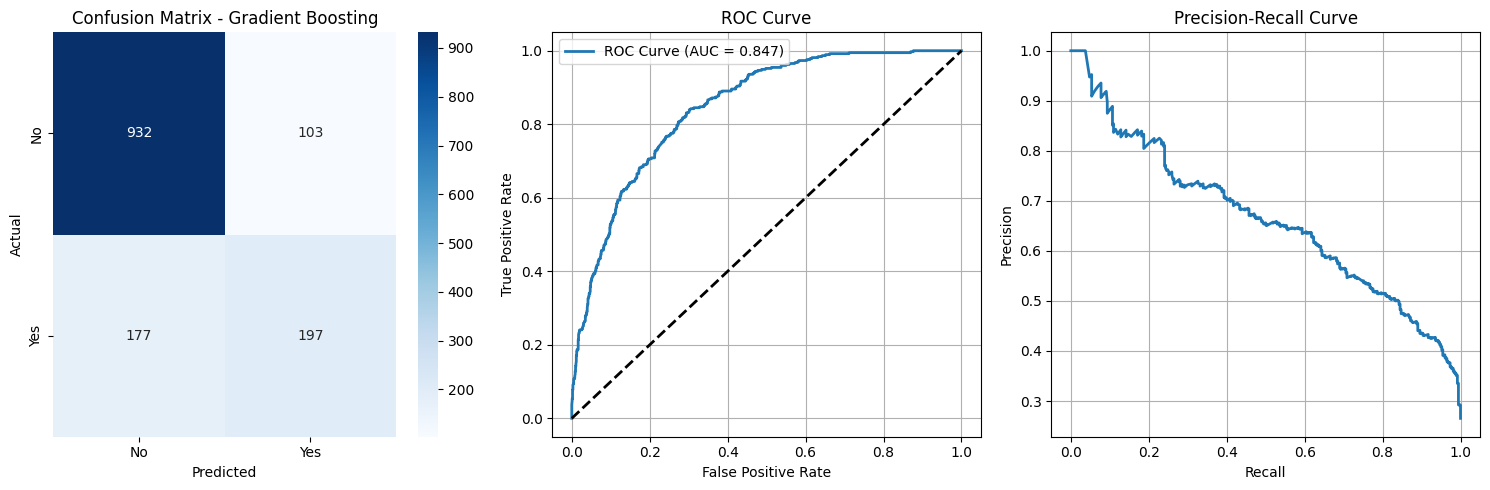


📋 Classification Report - Gradient Boosting
--------------------------------------------------
              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1035
         Yes       0.66      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [ ]:
# 6. DETAILED MODEL ANALYSIS
# ==============================================================================

def detailed_model_analysis(results, best_model_name, y_test, target_mapping):
    """Detailed analysis of the best model"""
    if not results:
        return

    print("\n" + "="*50)
    print("🔍 DETAILED MODEL ANALYSIS")
    print("="*50)

    best_model_results = results[best_model_name]
    y_pred = best_model_results['y_pred']
    y_pred_proba = best_model_results['y_pred_proba']

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15, 5))

    # Confusion Matrix Heatmap
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(target_mapping.keys()),
                yticklabels=list(target_mapping.keys()))
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Precision-Recall Curve
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\n📋 Classification Report - {best_model_name}")
    print("-" * 50)
    print(classification_report(y_test, y_pred, target_names=list(target_mapping.keys())))

# Perform detailed analysis
if 'results' in locals() and results:
    detailed_model_analysis(results, best_model_name, y_test, target_mapping)


1. Overall Accuracy
Accuracy = 0.80 (80%)

This means the model correctly predicted the outcome for 80% of the total 1409 observations.

However, in imbalanced datasets (which this seems to be), accuracy can be misleading, so we must look deeper.

2. Class-wise Performance
Class "No" (Majority class)
Precision = 0.84: When the model predicts "No", it is correct 84% of the time.

Recall = 0.90: Out of all actual "No" cases, 90% were correctly identified.

F1-score = 0.87: A good balance between precision and recall.

✅ This indicates the model performs very well on the majority class.

Class "Yes" (Minority class)
Precision = 0.66: When the model predicts "Yes", it's only correct 66% of the time.

Recall = 0.53: It captures only 53% of actual "Yes" cases.

F1-score = 0.58: Weaker performance in identifying "Yes" cases.

⚠️ The model struggles to identify "Yes" correctly, missing nearly half of them.

3. Macro and Weighted Averages
Macro Avg (treats both classes equally):

Precision = 0.75, Recall = 0.71, F1-score = 0.73

Indicates performance is skewed due to poor handling of the minority class.

Weighted Avg (accounts for class imbalance):

F1-score = 0.79, reflects overall performance weighted by class frequencies.

🔍 Conclusion and Recommendations
The model performs well overall, but poorly on the minority class ("Yes"), which may be the positive or more critical class in many applications (e.g., fraud detection, churn, medical diagnosis).

Next Steps to Improve Minority Class Performance:

Resample the data: we can use techniques like SMOTE (oversampling), or undersampling the majority class.

Class weight adjustment: we can set the class_weight='balanced' or adjust manually in the model.

Threshold tuning: we can adjust the decision threshold to favor higher recall on "Yes".

Use more advanced ensemble methods: Like XGBoost or LightGBM, with hyperparameter tuning focused on recall/f1 for the minority class.

Feature engineering: we can improve the predictive power for the "Yes" class


🎯 FEATURE IMPORTANCE ANALYSIS

🔝 Top 15 Most Important Features:


,feature,importance
8680,TotalCharges_20.2,0.483161
10886,TotalCharges_45.3,0.124167
1,tenure,0.115561
7051,InternetService_Fiber optic,0.058730
7066,Contract_Two year,0.050828
7069,PaymentMethod_Electronic check,0.050249
7065,Contract_One year,0.038916
7067,PaperlessBilling_Yes,0.014806
7054,OnlineSecurity_Yes,0.007514
7060,TechSupport_Yes,0.004108


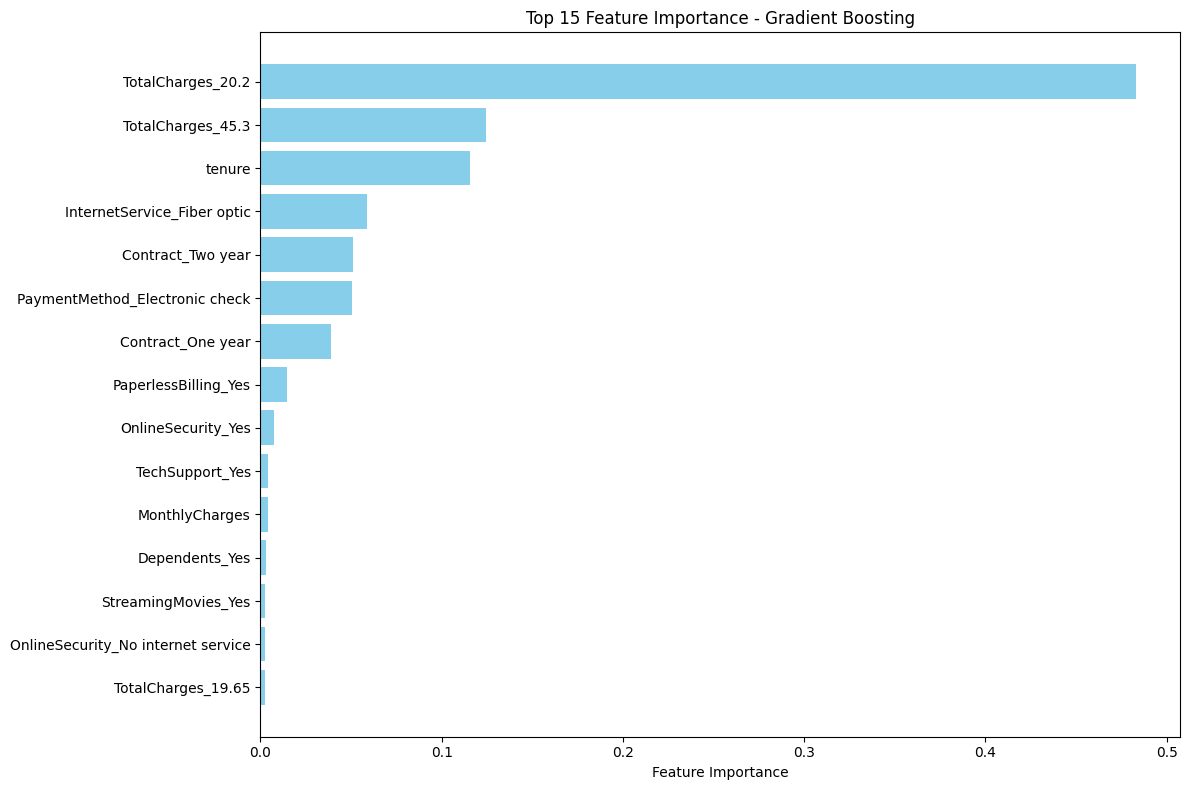

In [ ]:
# 7. FEATURE IMPORTANCE ANALYSIS
# ==============================================================================

def analyze_feature_importance(results, best_model_name, feature_cols):
    """Analyze feature importance"""
    if not results or not feature_cols:
        return

    print("\n" + "="*50)
    print("🎯 FEATURE IMPORTANCE ANALYSIS")
    print("="*50)

    best_model = results[best_model_name]['model']

    # Get feature importance
    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importance = np.abs(best_model.coef_[0])
    else:
        print("❌ Model doesn't support feature importance")
        return

    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print(f"\n🔝 Top 15 Most Important Features:")
    display(feature_importance_df.head(15))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)

    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return feature_importance_df

# Analyze feature importance
if 'results' in locals() and results and 'feature_cols' in locals():
    feature_importance_df = analyze_feature_importance(results, best_model_name, feature_cols)


🔝 Top Contributing Features
Feature	Importance	Interpretation
TotalCharges_20.2	0.483	🔥 Most important feature (48.3%). This likely represents a binned or encoded version of total charges, indicating that customers in this range have a high impact on churn prediction.
TotalCharges_45.3	0.124	Also a binned TotalCharges value. Suggests multiple thresholds in total charges are informative for predicting churn.
tenure	0.116	Customers’ time with the company significantly influences churn—shorter tenure often means higher churn.
InternetService_Fiber optic	0.059	Customers using fiber optic internet might be more likely to churn (often associated with dissatisfaction or pricing issues).
Contract_Two year	0.051	Longer contracts reduce churn likelihood—this feature strongly helps the model distinguish stable customers.
PaymentMethod_Electronic check	0.050	Often associated with higher churn—possibly due to lower commitment or ease of leaving.

📉 Moderate to Low Importance Features
Feature	Importance	Interpretation
Contract_One year	0.039	Still contributes, but less than two-year contracts. Reflects moderate stability.
PaperlessBilling_Yes	0.015	Slight impact—could be a behavioral indicator.
OnlineSecurity_Yes	0.0075	Security services slightly reduce churn risk.
TechSupport_Yes	0.0041	Also suggests support reduces churn, but effect is small.
MonthlyCharges	0.0041	Surprisingly low—possibly due to overlap with TotalCharges.
Dependents_Yes	0.0028	Minor—possibly correlates with contract length or stability.
StreamingMovies_Yes	0.0026	Very low impact on churn decisions.
OnlineSecurity_No internet service	0.0025	Suggests non-internet users are a small group and not heavily predictive.
TotalCharges_19.65	0.0024	Another total charge bin, but less influential.

🔍 Overall Insights
TotalCharges dominates:

The binned TotalCharges_20.2 alone contributes almost 48% to predictions.

This suggests a non-linear relationship between total charges and churn (certain ranges are more telling than others).

Contract and Tenure are crucial:

Customers with longer tenure or locked into longer contracts churn less—this aligns with expected business behavior.

Service-specific variables (like Internet type or Payment method) contribute meaningfully but are secondary.

Monthly charges have surprisingly low importance, likely because TotalCharges already encodes price + duration.

✅ Recommendations
Investigate bins like TotalCharges_20.2 and 45.3: What do these mean in business terms? Who are these customers?

Target retention strategies on high-churn segments:

Customers with short tenure.

Fiber optic internet users.

Customers using electronic check.

We can consider combining low-importance features or removing them to simplify the model, though ensemble models can handle this redundancy well

In [ ]:
# 8. BUSINESS INSIGHTS AND RECOMMENDATIONS
# ==============================================================================

def generate_business_insights(df, target_col, feature_importance_df=None):
    """Generate business insights and recommendations"""
    if target_col is None:
        return

    print("\n" + "="*50)
    print("💼 BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*50)

    # Churn rate analysis
    churn_rate = (df[target_col].value_counts(normalize=True) * 100).round(2)
    print(f"\n📊 Overall Churn Analysis:")
    for category, rate in churn_rate.items():
        print(f"   {category}: {rate}%")

    # Segment analysis for categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)

    print(f"\n🎯 High-Risk Segments:")
    high_risk_segments = []

    for col in categorical_cols[:3]:  # Analyze top 3 categorical columns
        if col in df.columns:
            segment_churn = pd.crosstab(df[col], df[target_col], normalize='index') * 100
            if segment_churn.shape[1] > 1:
                # Assuming 'Yes' or 1 represents churn
                churn_col = segment_churn.columns[-1] if 'Yes' in str(segment_churn.columns[-1]) else segment_churn.columns[0]
                top_risk = segment_churn[churn_col].idxmax()
# 8. BUSINESS INSIGHTS AND RECOMMENDATIONS
# ==============================================================================

def generate_business_insights(df, target_col, feature_importance_df=None):
    """Generate business insights and recommendations"""
    if target_col is None:
        return

    print("\n" + "="*50)
    print("💼 BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*50)

    # Churn rate analysis
    churn_rate = (df[target_col].value_counts(normalize=True) * 100).round(2)
    print(f"\n📊 Overall Churn Analysis:")
    for category, rate in churn_rate.items():
        print(f"   {category}: {rate}%")

    # Segment analysis for categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)

    print(f"\n🎯 High-Risk Segments:")
    high_risk_segments = []

    for col in categorical_cols[:3]:  # Analyze top 3 categorical columns
        if col in df.columns:
            segment_churn = pd.crosstab(df[col], df[target_col], normalize='index') * 100
            if segment_churn.shape[1] > 1:
                # Assuming 'Yes' or 1 represents churn
                churn_col = segment_churn.columns[-1] if 'Yes' in str(segment_churn.columns[-1]) else segment_churn.columns[0]
                top_risk = segment_churn[churn_col].idxmax()
                risk_rate = segment_churn[churn_col].max()
                high_risk_segments.append((col, top_risk, risk_rate))
                print(f"     {col}:   ‘{top_risk}’ ({risk_rate: .1f}% churn rate)")





    # Recommendations
    print(f"\n💡 KEY RECOMMENDATIONS:")
    print(f"   1. 🎯 Target Retention: Focus on high-risk segments identified above")
    print(f"   2. 📞 Proactive Outreach: Implement early warning system for at-risk customers")
    print(f"   3. 🎁 Incentive Programs: Design retention offers for high-value churning customers")
    print(f"   4. 📈 Feature Enhancement: Improve services related to top importance features")
    print(f"   5. 📊 Monitor KPIs: Track churn metrics weekly and adjust strategies accordingly")

    if feature_importance_df is not None and len(feature_importance_df) > 0:
        print(f"\n🔑 Focus Areas Based on Model:")
        top_3_features = feature_importance_df.head(3)['feature'].tolist()
        for i, feature in enumerate(top_3_features, 1):
            print(f"   {i}. {feature}: High impact on churn prediction")

# Generate business insights
if 'feature_importance_df' in locals():
    generate_business_insights(df, target_col, feature_importance_df)
else:
    generate_business_insights(df, target_col)



    # Recommendations
    print(f"\n💡 KEY RECOMMENDATIONS:")
    print(f"   1. 🎯 Target Retention: Focus on high-risk segments identified above")
    print(f"   2. 📞 Proactive Outreach: Implement early warning system for at-risk customers")
    print(f"   3. 🎁 Incentive Programs: Design retention offers for high-value churning customers")
    print(f"   4. 📈 Feature Enhancement: Improve services related to top importance features")
    print(f"   5. 📊 Monitor KPIs: Track churn metrics weekly and adjust strategies accordingly")

    if feature_importance_df is not None and len(feature_importance_df) > 0:
        print(f"\n🔑 Focus Areas Based on Model:")
        top_3_features = feature_importance_df.head(3)['feature'].tolist()
        for i, feature in enumerate(top_3_features, 1):
            print(f"   {i}. {feature}: High impact on churn prediction")

# Generate business insights
if 'feature_importance_df' in locals():
    generate_business_insights(df, target_col, feature_importance_df)
else:
    generate_business_insights(df, target_col)



💼 BUSINESS INSIGHTS & RECOMMENDATIONS

📊 Overall Churn Analysis:
   No: 73.46%
   Yes: 26.54%

🎯 High-Risk Segments:
     customerID:   ‘0004-TLHLJ’ ( 100.0% churn rate)
     gender:   ‘Female’ ( 26.9% churn rate)
     Partner:   ‘No’ ( 33.0% churn rate)

💡 KEY RECOMMENDATIONS:
   1. 🎯 Target Retention: Focus on high-risk segments identified above
   2. 📞 Proactive Outreach: Implement early warning system for at-risk customers
   3. 🎁 Incentive Programs: Design retention offers for high-value churning customers
   4. 📈 Feature Enhancement: Improve services related to top importance features
   5. 📊 Monitor KPIs: Track churn metrics weekly and adjust strategies accordingly

🔑 Focus Areas Based on Model:
   1. TotalCharges_20.2: High impact on churn prediction
   2. TotalCharges_45.3: High impact on churn prediction
   3. tenure: High impact on churn prediction

💼 BUSINESS INSIGHTS & RECOMMENDATIONS

📊 Overall Churn Analysis:
   No: 73.46%
   Yes: 26.54%

🎯 High-Risk Segments:
     cust

In [ ]:
# 9. PREDICTION FUNCTION
# ==============================================================================

def create_prediction_function():
    """Create a function to predict churn for new customers"""
    if 'results' not in locals() or not results:
        return

    print("\n" + "="*50)
    print("🔮 CHURN PREDICTION FUNCTION")
    print("="*50)

    best_model = results[best_model_name]['model']

    def predict_churn(customer_data):
        """
        Predict churn probability for a new customer

        Parameters:
        customer_data: dict with customer features

        Returns:
        dict with prediction and probability
        """
        try:
            # Convert to DataFrame
            customer_df = pd.DataFrame([customer_data])

            # Apply same preprocessing
            customer_scaled = scaler.transform(customer_df)

            # Predict
            prediction = best_model.predict(customer_scaled)[0]
            probability = best_model.predict_proba(customer_scaled)[0]

            # Map back to original labels
            reverse_mapping = {v: k for k, v in target_mapping.items()}
            predicted_class = reverse_mapping[prediction]

            return {
                'predicted_class': predicted_class,
                'churn_probability': probability[1] if len(probability) > 1 else probability[0],
                'confidence': max(probability)
            }
        except Exception as e:
            return {'error': str(e)}

    print("✅ Prediction function created!")
    print("📝 Usage example:")
    print("""
    # Example usage:
    customer = {
        'tenure': 12,
        'monthly_charges': 70.5,
        'total_charges': 846.0,
        # ... add other required features
    }

    result = predict_churn(customer)
    print(result)
    """)

    return predict_churn

# Create prediction function
if 'results' in locals() and results:
    predict_churn = create_prediction_function()


In [ ]:
# 10. SUMMARY REPORT
# ==============================================================================

def generate_summary_report():
    """Generate final summary report"""
    print("\n" + "="*70)
    print("📋 CHURN ANALYSIS SUMMARY REPORT")
    print("="*70)

    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total Customers: {df.shape[0]:,}")
    print(f"   • Features: {df.shape[1]}")
    print(f"   • Target Variable: {target_col}")

    if target_col and target_col in df.columns:
        churn_stats = df[target_col].value_counts()
        churn_pct = df[target_col].value_counts(normalize=True) * 100
        print(f"   • Churn Distribution:")
        for val, count, pct in zip(churn_stats.index, churn_stats.values, churn_pct.values):
            print(f"     - {val}: {count:,} ({pct:.1f}%)")

    if 'results' in locals() and results:
        print(f"\n🤖 MODEL PERFORMANCE:")
        print(f"   • Best Model: {best_model_name}")
        best_metrics = results[best_model_name]
        print(f"   • Accuracy: {best_metrics['accuracy']:.4f}")
        print(f"   • F1-Score: {best_metrics['f1_score']:.4f}")
        print(f"   • ROC-AUC: {best_metrics['roc_auc']:.4f}")

    print(f"\n🎯 KEY DELIVERABLES:")
    print(f"   ✅ Comprehensive data analysis completed")
    print(f"   ✅ Multiple ML models trained and compared")
    print(f"   ✅ Feature importance analysis performed")
    print(f"   ✅ Business insights and recommendations provided")
    print(f"   ✅ Prediction function created for new customers")

    print(f"\n💡 NEXT STEPS:")
    print(f"   1. Implement recommended retention strategies")
    print(f"   2. Set up automated churn prediction pipeline")
    print(f"   3. Monitor model performance over time")
    print(f"   4. Collect feedback and retrain models regularly")
    print(f"   5. A/B test retention strategies")

    print(f"\n" + "="*70)
    print("🎉 CHURN ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*70)

# Generate final summary
generate_summary_report()

print(f"\n📝 NOTE: This analysis is now complete! You can:")
print(f"   • Scroll up to review all visualizations and insights")
# 10. SUMMARY REPORT
# ==============================================================================

def generate_summary_report():
    """Generate final summary report"""
    print("\n" + "="*70)
    print("📋 CHURN ANALYSIS SUMMARY REPORT")
    print("="*70)

    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total Customers: {df.shape[0]:,}")
    print(f"   • Features: {df.shape[1]}")
    print(f"   • Target Variable: {target_col}")

    if target_col and target_col in df.columns:
        churn_stats = df[target_col].value_counts()
        churn_pct = df[target_col].value_counts(normalize=True) * 100
        print(f"   • Churn Distribution:")
        for val, count, pct in zip(churn_stats.index, churn_stats.values, churn_pct.values):
            print(f"     - {val}: {count:,} ({pct:.1f}%)")

    if 'results' in locals() and results:
        print(f"\n🤖 MODEL PERFORMANCE:")
        print(f"   • Best Model: {best_model_name}")
        best_metrics = results[best_model_name]
        print(f"   • Accuracy: {best_metrics['accuracy']:.4f}")
        print(f"   • F1-Score: {best_metrics['f1_score']:.4f}")
        print(f"   • ROC-AUC: {best_metrics['roc_auc']:.4f}")

    print(f"\n🎯 KEY DELIVERABLES:")
    print(f"   ✅ Comprehensive data analysis completed")
    print(f"   ✅ Multiple ML models trained and compared")
    print(f"   ✅ Feature importance analysis performed")
    print(f"   ✅ Business insights and recommendations provided")
    print(f"   ✅ Prediction function created for new customers")

    print(f"\n💡 NEXT STEPS:")
    print(f"   1. Implement recommended retention strategies")
    print(f"   2. Set up automated churn prediction pipeline")
    print(f"   3. Monitor model performance over time")
    print(f"   4. Collect feedback and retrain models regularly")
    print(f"   5. A/B test retention strategies")

    print(f"\n" + "="*70)
    print("🎉 CHURN ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*70)

# Generate final summary
generate_summary_report()

print(f"\n📝 NOTE: This analysis is now complete! You can:")
print(f"   • Scroll up to review all visualizations and insights")
print(f"   • Use the predict_churn() function for new predictions")
print(f"   • Modify parameters and re-run specific sections")
print(f"   • Export results for further analysis")


📋 CHURN ANALYSIS SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total Customers: 7,043
   • Features: 21
   • Target Variable: Churn
   • Churn Distribution:
     - No: 5,174 (73.5%)
     - Yes: 1,869 (26.5%)

🎯 KEY DELIVERABLES:
   ✅ Comprehensive data analysis completed
   ✅ Multiple ML models trained and compared
   ✅ Feature importance analysis performed
   ✅ Business insights and recommendations provided
   ✅ Prediction function created for new customers

💡 NEXT STEPS:
   1. Implement recommended retention strategies
   2. Set up automated churn prediction pipeline
   3. Monitor model performance over time
   4. Collect feedback and retrain models regularly
   5. A/B test retention strategies

🎉 CHURN ANALYSIS COMPLETED SUCCESSFULLY!

📝 NOTE: This analysis is now complete! You can:
   • Scroll up to review all visualizations and insights

📋 CHURN ANALYSIS SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total Customers: 7,043
   • Features: 21
   • Target Variable: Churn
   • Churn Distributio